In [1]:
import sys
import numpy as np
import cv2
import cv2.ml
from time import sleep
from datetime import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv, read_excel, DataFrame
#from sklearn.mixture import GaussianMixture
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
p = os.path.join('../../','raw','CookIRCamET','Images','CookTests','HiRes')
p2 = os.path.join('../../','work','CookIRCamET','Images','CookTests','HiRes')
n_feat = 4
n_components = 4

In [2]:
def localSD(mat, n):    
    mat=np.float32(mat)
    mu = cv2.blur(mat,(n,n))
    mdiff=mu-mat
    mat2=cv2.blur(np.float64(mdiff*mdiff),(n,n))
    sd = np.float32(cv2.sqrt(mat2))
    
    return sd

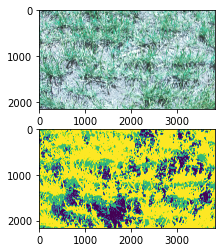

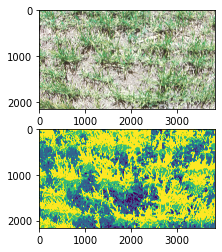

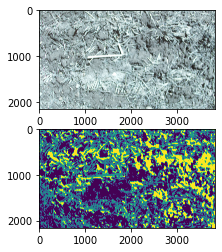

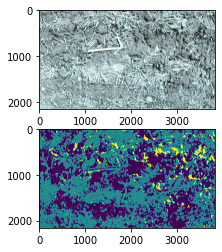

In [3]:
f_imgs=[]
test_imgs=[]
train_imgs=[]
for f in os.listdir(p):
    if 'bgr' in f:
        f_imgs = np.append(f_imgs,f)
        bgr = cv2.imread(os.path.join(p,f),cv2.IMREAD_UNCHANGED)
        f_labels = f.split('_bgr')[0]+'_labels.tif'
        labels = cv2.imread(os.path.join(p,f_labels),cv2.IMREAD_UNCHANGED)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        img = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        l,a,bb = cv2.split(lab)
        sd = localSD(l, 451)
        img_size = l.shape
        bb = bb.ravel()
        a = a.ravel()
        l = l.ravel()
        sd = sd.ravel()
        feat = np.vstack((l.T,a.T,bb.T,sd.T)).T
        plt.subplot(211)
        plt.imshow(bgr)
        plt.subplot(212)
        plt.imshow(labels)
        plt.show()
        #labels = np.sum(np.vstack((soil.ravel().T, residue.ravel().T*2, shadow.ravel().T*3, vegetation.ravel().T*4)).T,axis=1)
        labels = labels.ravel()
        if f.split('_')[0]=='20220509152045' or f.split('_')[0]=='20220509152630':
            train_imgs.append({'bgr':bgr,'feats':feat,'labels':labels})
        else:
            test_imgs.append({'bgr':bgr,'feats':feat,'labels':labels})

In [4]:
feats = []
labels = []
for sample in train_imgs:
    feats.append(sample['feats'])
    labels.append(sample['labels'])

In [5]:
for sample in test_imgs:
    feats.append(sample['feats'])
    labels.append(sample['labels'])

In [6]:
feats = np.array(feats).reshape((-1,n_feat)).astype(np.float32)
labels = np.array(labels).reshape((-1,1)).astype(np.int32)

In [7]:
data = cv2.ml.TrainData_create(feats,cv2.ml.ROW_SAMPLE,labels)
data.setTrainTestSplitRatio(.8,shuffle=True)
train_samples = data.getTrainSamples()
train_responses = data.getTrainResponses()
test_samples = data.getTestSamples()
test_responses = data.getTestResponses()

In [114]:
model_rt = cv2.ml.RTrees_create()
model_rt.setMaxCategories(4)
model_rt.setMaxDepth(4)
model_rt.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 250, 1e-6))
model_rt.train(train_samples,cv2.ml.ROW_SAMPLE,train_responses)
_,pred_rt = model_rt.predict(test_samples)

In [ ]:
model_nb = cv2.ml.NormalBayesClassifier_create()
#model_nb.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 250, 1e-6))
model_nb.train(train_samples,cv2.ml.ROW_SAMPLE,train_responses)
_, pred_nb = model_nb.predict(test_samples)

pred_nb = pred_nb.astype(np.int32)

In [ ]:
model_em  = cv2.ml.EM_create()
model_em.setClustersNumber(4)
model_em.setCovarianceMatrixType(cv2.ml.EM_COV_MAT_DIAGONAL)
model_em.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 250, 1e-6))
_ , _ , pred_em_train , _ = model_em.trainEM(train_samples)
_ , pred_em_test = model_em.predict(test_samples)

pred_em = np.argmax(pred_em_test,axis=1).reshape((-1,1))

In [ ]:
model_svm_rbf = cv2.ml.SVM_create()
model_svm_rbf.setType(cv2.ml.SVM_C_SVC)
model_svm_rbf.setKernel(cv2.ml.SVM_RBF)
model_svm_rbf.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 250, 1e-6))
model_svm_rbf.trainAuto(train_samples,cv2.ml.ROW_SAMPLE,train_responses)
_,pred_svm_rbf = model_svm_rbf.predict(test_samples)

pred_svm_rbf = pred_svm_rbf.astype(np.int32)

In [ ]:
model_svm_lin = cv2.ml.SVM_create()
model_svm_lin.setType(cv2.ml.SVM_C_SVC)
model_svm_lin.setKernel(cv2.ml.SVM_LINEAR)
model_svm_lin.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 250, 1e-6))
model_svm_lin.trainAuto(train_samples,cv2.ml.ROW_SAMPLE,train_responses)
_,pred_svm_lin = model_svm_lin.predict(test_samples)

pred_svm_lin = pred_svm_lin.astype(np.int32)

In [ ]:
model_svm_pol = cv2.ml.SVM_create()
model_svm_pol.setType(cv2.ml.SVM_C_SVC)
model_svm_pol.setKernel(cv2.ml.SVM_POLY)
model_svm_pol.setDegree(2)
model_svm_pol.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 250, 1e-6))
model_svm_pol.trainAuto(train_samples,cv2.ml.ROW_SAMPLE,train_responses)
_,pred_svm_pol = model_svm_pol.predict(test_samples)

pred_svm_pol = pred_svm_pol.astype(np.int32)

In [ ]:
def cornfusion(obs,pred,nclass):
    M = np.zeros((nclass,nclass))
    for i in range(obs.shape[0]):
        o = obs[i][0]
        p = pred[i][0]
        M[o,p] = M[o,p]+1
    return M

In [ ]:
M_svm_rbf = cornfusion(test_responses,pred_svm_rbf,n_components)

M_svm_lin = cornfusion(test_responses,pred_svm_lin,n_components)

M_svm_pol = cornfusion(test_responses,pred_svm_pol,n_components)

M_nb = cornfusion(test_responses,pred_nb,n_components)

M_rt = cornfusion(test_responses,pred_rt,n_components)

M_em = cornfusion(test_responses,pred_em,n_components)

M_rt = M_rt/np.sum(M_rt,axis=1).reshape((-1,1))

M_nb = M_nb/np.sum(M_nb,axis=1).reshape((-1,1))

M_svm_rbf = M_svm_rbf/np.sum(M_svm_rbf,axis=1).reshape((-1,1))

M_svm_lin = M_svm_lin/np.sum(M_svm_lin,axis=1).reshape((-1,1))

M_svm_pol = M_svm_pol/np.sum(M_svm_pol,axis=1).reshape((-1,1))

M_em = M_em/np.sum(M_em,axis=1).reshape((-1,1))